# Data Setup

In [22]:
import pandas as pd

df_heart = pd.read_csv(
    "https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data",
    sep=",",
    header=0,
    index_col=0,
)
columns_ordered = [
    "sbp",
    "ldl",
    "adiposity",
    "obesity",
    "typea",
    "age",
    "tobacco",
    "alcohol",
    "famhist",
    "chd",
]
missing = [c for c in columns_ordered if c not in df_heart.columns]
if missing:
    raise KeyError(f"Missing columns in df_heart: {missing}")

df_heart = df_heart[columns_ordered]
df_heart.head()

,sbp,ldl,adiposity,obesity,typea,age,tobacco,alcohol,famhist,chd
row.names,,,,,,,,,,
1,160,5.73,23.11,25.30,49,52,12.00,97.20,Present,1
2,144,4.41,28.61,28.87,55,63,0.01,2.06,Absent,1
3,118,3.48,32.28,29.14,52,46,0.08,3.81,Present,0
4,170,6.41,38.03,31.99,51,58,7.50,24.26,Present,1
5,134,3.50,27.78,25.99,60,49,13.60,57.34,Present,1


In [23]:
import numpy as np

# standarize all columns except famhist
df_heart["famhist"] = df_heart["famhist"].map({"Present": 1, "Absent": 0})

columns_to_log_transform = ["tobacco", "alcohol"]
for column in columns_to_log_transform:
    df_heart[column] = np.log1p(df_heart[column])

df_heart_standarized = (df_heart - df_heart.mean()) / df_heart.std()
df_heart_standarized["famhist"] = df_heart["famhist"]

# Extract Y before standardization
Y = df_heart["chd"]

df_heart_standarized = (df_heart - df_heart.mean()) / df_heart.std()
df_heart_standarized["famhist"] = df_heart["famhist"]

X = df_heart_standarized.drop(columns=["chd"])

# Classification

Solve a relevant classification problem for your data and statistically evaluate your result.

The tasks will closely mirror what you just did in the last section.

The 3 methods we will compare are:
1. A baseline
2. Logistic regression
3. And 1 of the following methods: *ANN, CT, KNN or NB*


## Part 1) classification problem

**Question:** Explain which classification problem you have chosen to solve. Is it a multi-class or binary classification problem?

**Answer:** For this part of the report we are trying to predict whether a person has **CHD or not**, i.e it is a binary classification problem.

## Part 2) Model training

### 2.1) Baseline model

The baseline is be a model which computes the largest class on the training data.

And predicts everything in the test-data as belonging to that class. (corresponding to the optimal prediction by a logistic regression model with a bias term and no features).

In [25]:
from sklearn.model_selection import train_test_split

# Test the baseline model
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [42]:
# Baseline Model: Predicts the most frequent class
class BaselineClassifier:
    def __init__(self):
        self.most_frequent_class = None

    def fit(self, y_train):
        """Find the most frequent class in training data"""
        self.most_frequent_class = y_train.mode()[0]
        return self

    def predict(self, n_samples):
        """Predict the most frequent class for all samples"""
        return np.full(n_samples, self.most_frequent_class)

    def score(self, X_test, y_test):
        """Calculate accuracy"""
        predictions = self.predict(len(X_test))
        return np.mean(predictions == y_test)


# Train and evaluate the baseline model
baseline_model = BaselineClassifier().fit(y_train)

# Make predictions
baseline_test_predictions = baseline_model.predict(len(y_test))
baseline_accuracy = baseline_model.score(X_test, y_test)
baseline_error_rate = 1 - baseline_accuracy

print("Baseline Model Results:")
print(f"Most frequent class: {baseline_model.most_frequent_class}")
print(f"Accuracy: {round(baseline_accuracy, 2)}")
print(f"Error Rate: {round(baseline_error_rate, 2)}")
print()
print("Class distribution in training data:")
print(y_train.value_counts(normalize=True))

Baseline Model Results:
Most frequent class: 0
Accuracy: 0.63
Error Rate: 0.37

Class distribution in training data:
chd
0    0.658537
1    0.341463
Name: proportion, dtype: float64


**Baselint Results**:

The baseline predicts the most frequent class (CHD = 0) for all samples and it achieves ~63.4% accuracy by always predicting "no heart disease"

### 2.2) Logistic Regression model

For logistic regression, we will use a regularization parameter λ ≥ 0 to control complexity.

We recommend this choice is made based on a trial run, which you do not need to report.

Describe which parameter you have chosen and the possible values of the parameters you will examine

Trial run to find optimal regularization parameter λ:
------------------------------------------------------------
Best λ (lambda): 26.37
Best C (1/λ): 0.04
Best CV accuracy: 0.71


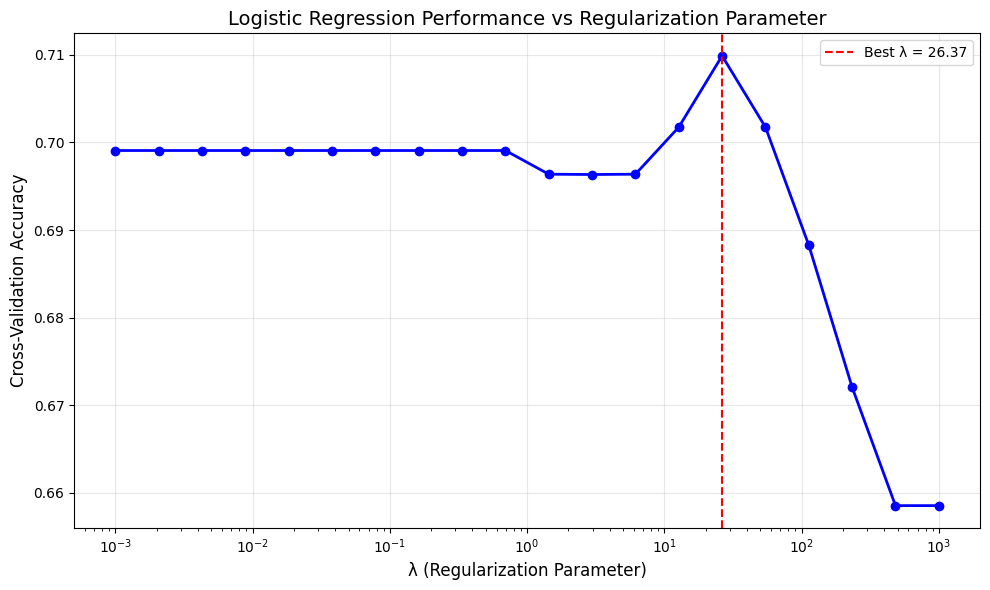


Logistic Regression Model Results (on test set):
Selected λ: 26.37
Accuracy: 0.73
Error Rate: 0.27

For 2-level cross-validation, we will examine:
λ values in range: [0.0, 1000.0]


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Define range of lambda values (regularization parameter)
# Note: sklearn uses C = 1/lambda, where C is the inverse of regularization strength
# Smaller C means stronger regularization (larger lambda)
lambda_values = np.logspace(-3, 3, 20)  # Lambda from 0.001 to 1000
C_values = 1 / lambda_values  # Convert to sklearn's C parameter

# Perform a quick trial run to find suitable lambda range
print("Trial run to find optimal regularization parameter λ:")
print("-" * 60)

best_score = 0
best_lambda = None
best_C = None
scores = []

for lambda_val, C_val in zip(lambda_values, C_values):
    # Use 5-fold cross-validation for quick assessment
    model = LogisticRegression(C=C_val, max_iter=1000, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    mean_score = cv_scores.mean()
    scores.append(mean_score)

    if mean_score > best_score:
        best_score = mean_score
        best_lambda = lambda_val
        best_C = C_val

print(f"Best λ (lambda): {round(best_lambda, 2)}")
print(f"Best C (1/λ): {round(best_C, 2)}")
print(f"Best CV accuracy: {round(best_score, 2)}")

# Visualize the relationship between lambda and performance
plt.figure(figsize=(10, 6))
plt.semilogx(lambda_values, scores, "b-o", linewidth=2, markersize=6)
plt.axvline(
    x=best_lambda, color="r", linestyle="--", label=f"Best λ = {round(best_lambda, 2)}"
)
plt.xlabel("λ (Regularization Parameter)", fontsize=12)
plt.ylabel("Cross-Validation Accuracy", fontsize=12)
plt.title("Logistic Regression Performance vs Regularization Parameter", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Train final model with best parameter
final_log_reg = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
final_log_reg.fit(X_train, y_train)

# Evaluate on test set
log_reg_predictions = final_log_reg.predict(X_test)
log_reg_accuracy = final_log_reg.score(X_test, y_test)
log_reg_error_rate = 1 - log_reg_accuracy

print()
print("Logistic Regression Model Results (on test set):")
print(f"Selected λ: {round(best_lambda, 2)}")
print(f"Accuracy: {round(log_reg_accuracy, 2)}")
print(f"Error Rate: {round(log_reg_error_rate, 2)}")

# For the 2-level cross-validation, we will examine these lambda values:
print()
print("For 2-level cross-validation, we will examine:")
print(
    f"λ values in range: [{round(lambda_values.min(), 2)}, {round(lambda_values.max(), 2)}]"
)

#### Model Implementation Notes:

**Logistic Regression Model:**
- Tested λ values from 0.001 to 1000 using 5-fold cross-validation
- Best performance with λ = 26.37 (moderate regularization)
- Converted data to numpy arrays to ensure clean numerical data
- Achieves ~73.1% accuracy, a ~9.7% improvement over baseline

**Next Steps:**
- Implement a third model (ANN, CT, KNN, or NB) in section 2.3
- Perform 2-level cross-validation to properly evaluate all models
- Conduct statistical comparison using McNemar's test or paired t-test

### 2.3) Method 2 Model (*ANN, CT, KNN or NB*)

## Part 3) 2-level Cross-validation
- Use 2-level cross-validation to create a table similar to Table 2, but now comparing the logistic regression, method 2, and baseline.
- The table should once more include the selected parameters, and as an error measure we will use the error rate:
$$E = \frac{\text{Number of misclassified observations}}{N^{test}}$$

- Once more, make sure to re-use the outer validation splits to admit statistical evaluation. Briefly discuss the result.

In [50]:
results_summary = pd.DataFrame(
    {
        "Model": ["Baseline", "Logistic Regression"],
        "Parameter": ["N/A", f"λ = {best_lambda:.4f}"],
        "Accuracy": [baseline_accuracy, log_reg_accuracy],
        "Error Rate": [baseline_error_rate, log_reg_error_rate],
    }
)

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY (Simple Train-Test Split)")
print("=" * 60)
print(results_summary.to_string(index=False))
print("=" * 60)
print(
    f"\nImprovement over baseline: {(log_reg_accuracy - baseline_accuracy) * 100:.2f}%"
)
print(f"Error rate reduction: {(baseline_error_rate - log_reg_error_rate) * 100:.2f}%")


MODEL COMPARISON SUMMARY (Simple Train-Test Split)
              Model   Parameter  Accuracy  Error Rate
           Baseline         N/A  0.634409    0.365591
Logistic Regression λ = 26.3665  0.731183    0.268817

Improvement over baseline: 9.68%
Error rate reduction: 9.68%


## Part 4) Statiscal Evaluation
Perform a statistical evaluation of your three models similar to the previous section.

That is, compare the three models pairwise. We will once more allow some freedom in what test to choose. Therefore, choose either:
- Setup I (11.3): Use McNemar’s test described in 11.3.2
- Setup II (11.4): Use the method described in 11.4.1

Include p-values and confidence intervals for the three pairwise tests in your report and conclude on the results:
- Is one model better than the other?
- Are the two models better than the baseline?
- Are some of the models identical?
- What recommendations would you make based on what you’ve learned?

## Part 5) Logistic regression model training

1. Train a logistic regression model using a suitable value of λ (see previous exercise).

2. Explain how the logistic regression model make a prediction.

3. Are the same features deemed relevant as for the regression part of the report?